## Importing libraries and setup

In [1]:
!pip install torchsummary 

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

import seaborn as sn
import pandas as pd
from torchsummary import summary

In [3]:
print(torchvision.__version__)

0.12.0


## Data Preprocessing and Augmentation

In [4]:
BATCH_SIZE = 8

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/iitm-edutech-electrical/Electrical - Dataset'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']
                 }

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
              for x in ['train', 'test']
              }

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (20,3))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pausing so that plots are updated

training data - samples


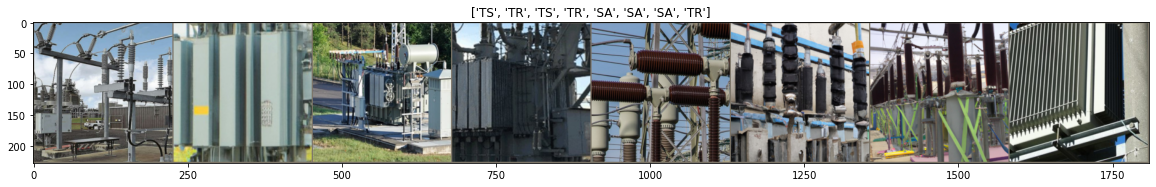

In [7]:
print("training data - samples")
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

test data - samples


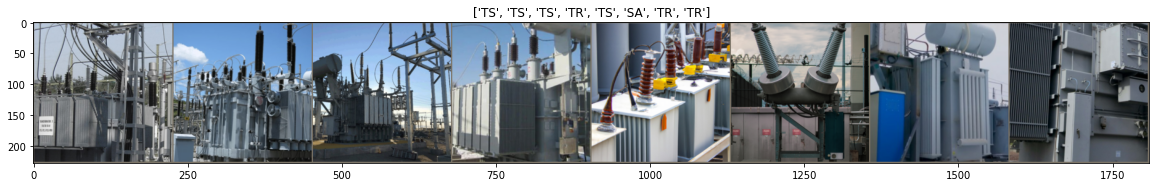

In [8]:
print("test data - samples")
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Creating and Training the model 

In [9]:
def train_model(model, criterion, optimizer, scheduler, history, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_history = {"loss":[], "acc":[]}
    test_history = {"loss":[], "acc":[]}
    

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
#             if phase == 'test':
#                 scheduler.step(epoch_loss)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            if phase == 'train':
                train_history['acc'].append(epoch_acc)
                train_history['loss'].append(epoch_loss)
            else:
                test_history['acc'].append(epoch_acc)
                test_history['loss'].append(epoch_loss)

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    history["test"] = test_history
    history["train"] = train_history
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                print(f'predicted: {class_names[preds[j]]}')
                # ax = plt.subplot(num_images//2, 2, images_so_far)
                # ax.axis('tight')
                # ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                print('---------------------------------')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

We are using ResNet18 pre-trained on imagenet along with our own classification layer. We are using SGD as our optimizer. 

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs - 
# NOT BEING USED AS CONSTANT LR PRODUCED HIGHER ACCURACY
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min')


summary(model_ft, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [12]:
history = {}
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, history, num_epochs=50)

Epoch 0/49
----------
train Loss: 1.1023 Acc: 0.4531
test Loss: 0.7701 Acc: 0.6667
Epoch 1/49
----------
train Loss: 0.7926 Acc: 0.6146
test Loss: 0.7126 Acc: 0.6852
Epoch 2/49
----------
train Loss: 0.5614 Acc: 0.7917
test Loss: 0.6476 Acc: 0.7222
Epoch 3/49
----------
train Loss: 0.5308 Acc: 0.7708
test Loss: 0.5641 Acc: 0.7593
Epoch 4/49
----------
train Loss: 0.5863 Acc: 0.7500
test Loss: 0.5188 Acc: 0.7778
Epoch 5/49
----------
train Loss: 0.3609 Acc: 0.8490
test Loss: 0.7174 Acc: 0.7593
Epoch 6/49
----------
train Loss: 0.4954 Acc: 0.8333
test Loss: 0.3945 Acc: 0.8333
Epoch 7/49
----------
train Loss: 0.3764 Acc: 0.8854
test Loss: 0.3828 Acc: 0.8333
Epoch 8/49
----------
train Loss: 0.3679 Acc: 0.8646
test Loss: 0.4470 Acc: 0.7593
Epoch 9/49
----------
train Loss: 0.3454 Acc: 0.8854
test Loss: 0.4474 Acc: 0.7778
Epoch 10/49
----------
train Loss: 0.3919 Acc: 0.8542
test Loss: 0.3978 Acc: 0.8148
Epoch 11/49
----------
train Loss: 0.3762 Acc: 0.8646
test Loss: 0.5576 Acc: 0.7407
Ep

predicted: TS


<Figure size 432x288 with 0 Axes>

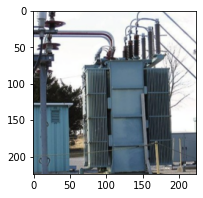

---------------------------------
predicted: SA


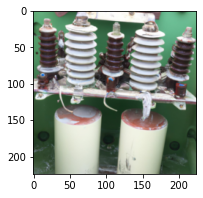

---------------------------------
predicted: SA


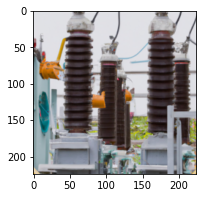

---------------------------------
predicted: TS


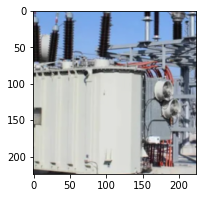

---------------------------------
predicted: TR


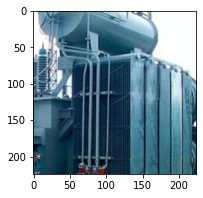

---------------------------------
predicted: SA


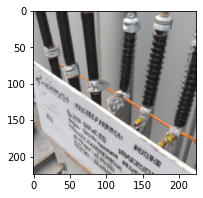

---------------------------------


In [13]:
visualize_model(model_ft)

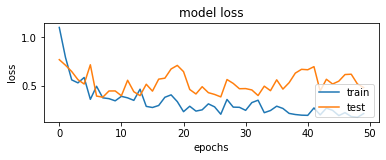

In [14]:
plt.subplot(2,1,1)
plt.plot(history["train"]["loss"], label='train loss')
plt.plot(history["test"]["loss"], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend(['train', 'test'], loc='lower right')
plt.show()


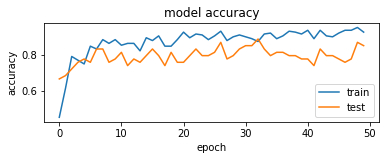

In [15]:
plt.subplot(2,1,1)
plt.plot(torch.Tensor(history['train']['acc']).cpu(), label='train accuracy')
plt.plot(torch.Tensor(history['test']['acc']).cpu(), label='train accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

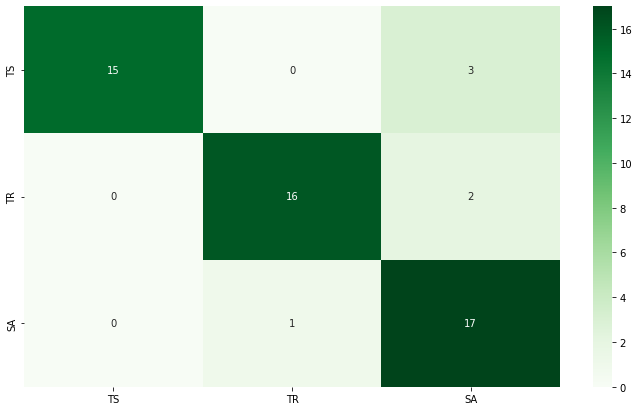

In [16]:
y_pred = []
y_true = []

# iterate over test data
for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model_ft(inputs)
        _, preds = torch.max(output, 1)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('TS', 'TR', 'SA')

# print('Confusion Matrix:')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
#print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, cmap='Greens')
plt.savefig('output.png')

In [17]:
report = classification_report(
    y_true, 
    y_pred, 
    target_names=classes
)
print(report)

              precision    recall  f1-score   support

          TS       1.00      0.83      0.91        18
          TR       0.94      0.89      0.91        18
          SA       0.77      0.94      0.85        18

    accuracy                           0.89        54
   macro avg       0.90      0.89      0.89        54
weighted avg       0.90      0.89      0.89        54



In [18]:
y_pred_train = []
y_true_train = []

# iterate over train data
for i, (inputs, labels) in enumerate(dataloaders['train']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model_ft(inputs)
        _, preds = torch.max(output, 1)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred_train.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true_train.extend(labels) # Save Truth

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
kappa_test = cohen_kappa_score(y_pred, y_true, weights=None, sample_weight=None)
kappa_train = cohen_kappa_score(y_pred_train, y_true_train, weights=None, sample_weight=None)

print(f"The Kappa Score for the Train data is {kappa_train}" )
print(f"The Kappa Score for the Validation data is {kappa_test}" )

The Kappa Score for the Train data is 0.9375
The Kappa Score for the Validation data is 0.8333333333333334
